In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import scipy
import scipy.ndimage as npimage
import imageio
import re
import math

# Project Goal(s) and general overview

This program has the goal to perform a semiautomatic count of the number of cells, as well as how many cells (defined by blue nuclei) are marked as green and/or red (or none) using a combination of user input, with their human intuition being used to determine filter levels and maximum distance to make assignments, and Python to automate counting.

-user manually adjusts the filter level of image to a level they feel most comfortable with.

Program will:
-accept 3  black and white "channels" from the same microscopy image of cells" collected as raw tiff images, one of the blue channel, one red channel, one green channel.

-count number of cell nuclei in an image with b/w tiff image of blue dapi channel, parameters filtering for brightness beaks for counting will be defined by the user. We could employ special tactics to distinguish area sizes to get a more accurate cell count, but there are several mega cancer cells in my photo that should only be counted as once cell
  
-mark down the coordinates of the center of the nuclei enclosed by smallest rectangles

-count number of "blobs" of pigment using same method for cell nuclei, but instead the center of all blobs is assigned to the nearest nucleus. If the distance is larger than the parameter defined by the user, the blob will skip being assigned.
    -if color of blob is already assigned to the nucleus, it is only ever counted once.
  
-cell nuclei coordinates are categorized based in whether they match at least one red blob, green blob, or both.
-number of "none" marked nuclei are determined by subtracting total counted pigmented cells minus number of total nuclei.
-totals are counted up and displayed to the user.

# How to use the program

1. Before running the python script, run each of the channel images provided for filtering, and write down the value that feels best to you. Make sure to write down the file names for each channel. Make sure the channel images are in the same folder as the python program.
2. Look at the full image with channels combined, pick out the farthest cell marker from it's nuclei that you would personally count as being associated(not a fluke in staining) write down the approximate distance in pixels.
3. Run the program 'ProjectHTD.py' from the command line by first redirecting to the command directory using command cd.
4. Direct the command line to the location of the python program by pasting in the file directory of the program.
5. Run the program by using the command "python ProjectHTD.py"
6. Input the name of the files, the filtering values, and maximum distance when prompted.
7. The output will be delivered to the folder as a txt file, or you can write down the values delivered from the command prompt.



# testing the function on virtual images before we move on to microscope images

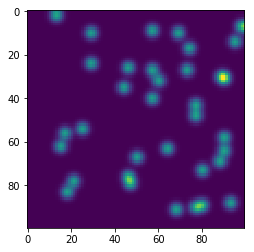

In [5]:
points_n = np.random.random((100,100)) #generating a random image of blob to use as the "blue" channel using methods described in previous class notes
#plt.imshow(points)
points_n = points_n>0.997
points_n = points_n.astype(int)
#plt.imshow(points)
points_n = points_n.astype(float)
blobs_n = scipy.ndimage.gaussian_filter(points_n,2)
plt.imshow(blobs_n)

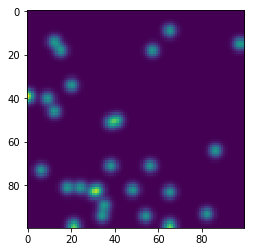

In [6]:
points_g = np.random.random((100,100)) #generating a random image of blob to use as the "green" channel using methods described in previous class notes
#plt.imshow(points)
points_g = points_g>0.997
points_g = points_g.astype(int)
#plt.imshow(points)
points_g = points_g.astype(float)
blobs_g = scipy.ndimage.gaussian_filter(points_g,2)
plt.imshow(blobs_g)

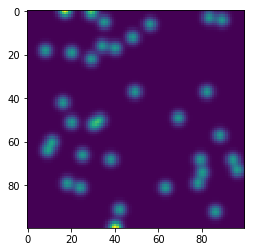

In [7]:
points_r = np.random.random((100,100)) #generating a random image of blob to use as the "red" channel using methods described in previous class notes
#plt.imshow(points)
points_r = points_r>0.997
points_r = points_r.astype(int)
#plt.imshow(points)
points_r = points_r.astype(float)
blobs_r = scipy.ndimage.gaussian_filter(points_r,2)
plt.imshow(blobs_r)

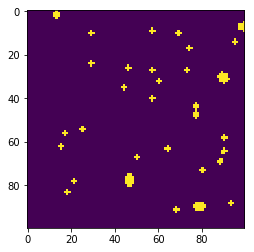

In [8]:
blobs_n_filt = (blobs_n>0.035).astype(int)#checking filtering values of blobs_n manually to find a general idea of a good filter number
plt.imshow(blobs_n_filt) #0.035 seems to be a good number

In [9]:
labels = scipy.ndimage.label(blobs_n_filt)[0] #using scypi ndimage to define and count blobs, then draw the smallest rectangle around each blob
rects = scipy.ndimage.find_objects(labels)
rects #as you can see if we want the coordinites of the rectangles, we need the information stored here, but how to get it out?

[(slice(0, 4, None), slice(12, 15, None)),
 (slice(5, 10, None), slice(97, 100, None)),
 (slice(8, 11, None), slice(56, 59, None)),
 (slice(9, 12, None), slice(28, 31, None)),
 (slice(9, 12, None), slice(68, 71, None)),
 (slice(13, 16, None), slice(94, 97, None)),
 (slice(16, 19, None), slice(73, 76, None)),
 (slice(23, 26, None), slice(28, 31, None)),
 (slice(25, 28, None), slice(45, 48, None)),
 (slice(26, 29, None), slice(56, 59, None)),
 (slice(26, 29, None), slice(72, 75, None)),
 (slice(28, 34, None), slice(87, 93, None)),
 (slice(31, 34, None), slice(59, 62, None)),
 (slice(34, 37, None), slice(43, 46, None)),
 (slice(39, 42, None), slice(56, 59, None)),
 (slice(42, 50, None), slice(76, 79, None)),
 (slice(53, 56, None), slice(24, 27, None)),
 (slice(55, 58, None), slice(16, 19, None)),
 (slice(57, 60, None), slice(89, 92, None)),
 (slice(61, 64, None), slice(14, 17, None)),
 (slice(62, 65, None), slice(63, 66, None)),
 (slice(63, 66, None), slice(89, 92, None)),
 (slice(66, 69,

In [10]:
# this was the best solution I could find for finding the coordinates from the rectangle data
'''this is a bit of a hack but we convert each element in the list to a string and seach for integers using the re module'''

def find_centers(rects): 
    list_coor = []
    counter = 0
    for i in rects:
        
        r = i[0]
        c = i[1]
        strr = str(r)
        strc = str(c)



        a = strr.find(',') #finds commas where numbers will be
        b = strc.find(',')
        strr2 = strr[a:]
        strc2 = strc[b:]
        intr1 = int(re.search(r'\d+', strr).group()) #each of these finds integers in a string
        intr2 = int(re.search(r'\d+', strr2).group())

        intc1 = int(re.search(r'\d+', strc).group())
        intc2 = int(re.search(r'\d+', strc2).group())

        center_r = (intr1+intr2)/2
        center_c = (intc1+intc2)/2

        center_coordinates = center_r,center_c #converts recrtangle coordinates to the coordinates of the center of the rectangles
        list_coor.append(center_coordinates)
        counter +=1
    return list_coor
    

In [11]:
nuclei_centers = find_centers(rects) #testing out the find_centers function

nuclei_centers

[(2.0, 13.5),
 (7.5, 98.5),
 (9.5, 57.5),
 (10.5, 29.5),
 (10.5, 69.5),
 (14.5, 95.5),
 (17.5, 74.5),
 (24.5, 29.5),
 (26.5, 46.5),
 (27.5, 57.5),
 (27.5, 73.5),
 (31.0, 90.0),
 (32.5, 60.5),
 (35.5, 44.5),
 (40.5, 57.5),
 (46.0, 77.5),
 (54.5, 25.5),
 (56.5, 17.5),
 (58.5, 90.5),
 (62.5, 15.5),
 (63.5, 64.5),
 (64.5, 90.5),
 (67.5, 50.5),
 (69.5, 88.5),
 (73.5, 80.5),
 (78.0, 47.0),
 (78.5, 21.5),
 (83.5, 18.5),
 (88.5, 93.5),
 (90.0, 79.0),
 (91.5, 68.5)]

In [12]:
def find_dist(p1,p2):
    '''simple formula to find the distance between two coordinates, we will need this later'''
    distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )

    return(distance)

In [13]:
p1 = nuclei_centers[0] #testing the nuclei_centers function
p2 = nuclei_centers[1]
find_dist(p1,p2)

85.17775531205316

In [14]:
def find_all_dist(list1,list_n,maxd=-1):
    '''given list1 of points, will find the closest point in list2 for that particular point, and gives distance'''
    #NUCLEI COORDINATES MUST BE SECOND LIST, NOT FIRST
    short_dist_info_total = []
    for i in list1:
        dist_list = []
        p1 = i
        for j in list_n: #for loop within a for loop, computationally expensive and could be optimized, but it works and is the easiest solution to find closest nuclei 
            p2 = j
            d = find_dist(p1,p2)
                    
            dist_list.append(d)
        smallest = min(dist_list) #finds smallest distance nuclei in the list
        p = 0 #counts number of elements in list to find index of smallest distance nuclei
        for k in dist_list:
            
            if k == smallest:
                dist_index = list_n[p]
                
            p+=1
          
        short_dist_info = [i,dist_index,smallest]
        if maxd != -1: #if distance is not listed or user specifies -1, it ignores checking max distance
            if smallest <=maxd: # checks if distance is smaller than optional max distance maxd argument, if it's bigger, it's not added to the list
                short_dist_info_total.append(short_dist_info) 
        else:
            short_dist_info_total.append(short_dist_info) 
    return short_dist_info_total# [list1coordinate, list2coordinate, distance] # returns the coordinate of the point that a point on list1 was closest with on list2, as well as the distance this was

In [15]:
list1 = [(12.2, 11.5),(100,99),(50,50),(50,99),(1,2)] #list of random coordinates
example = find_all_dist(list1,nuclei_centers) #testing the find_all_dist function
example

[[(12.2, 11.5), (2.0, 13.5), 10.394229168149026],
 [(100, 99), (88.5, 93.5), 12.747548783981962],
 [(50, 50), (40.5, 57.5), 12.103718436910205],
 [(50, 99), (58.5, 90.5), 12.020815280171307],
 [(1, 2), (2.0, 13.5), 11.543396380615196]]

In [16]:
example2 = find_all_dist(list1,nuclei_centers,14) #testing optional max distance variable, ignores the higher distance nuclei
example2

[[(12.2, 11.5), (2.0, 13.5), 10.394229168149026],
 [(100, 99), (88.5, 93.5), 12.747548783981962],
 [(50, 50), (40.5, 57.5), 12.103718436910205],
 [(50, 99), (58.5, 90.5), 12.020815280171307],
 [(1, 2), (2.0, 13.5), 11.543396380615196]]

In [17]:
def list_sort(r_list,g_list): # will need this later
    '''if value from r_list1 is found on g_list, removes both matching values from lists and adds them to a list of both r and g'''
    g_r_list = []
    for i in r_list:
        for j in g_list: #for loop within a for loop to search for matching values in lists
            if i ==j:
                g_r_list.append(j)
                r_list.remove(i) #important, if a nucleus is found to be both red and green, it's coordinates are removed from each red and green list
                g_list.remove(j)
    return r_list,g_list,g_r_list     
    

In [18]:
list7 = [1,2,3,4,5] #testing list_sort function
list6 = [1,5,8,9,10]
list_sort(list7,list6)

([2, 3, 4], [8, 9, 10], [1, 5])

In [19]:
def rect_obj(image, filt):
    '''calls on functions created above to process an image to find the center coordinates of all blobs defined by enclosing rectangles'''
    blobs_filt = (image>filt).astype(int)
    
    labels = scipy.ndimage.label(blobs_filt)[0]
    rect = scipy.ndimage.find_objects(labels)
    centers = find_centers(rect)
    return centers

In [20]:
rect_obj(blobs_n, 0.035) #testing the rect_obj function

[(2.0, 13.5),
 (7.5, 98.5),
 (9.5, 57.5),
 (10.5, 29.5),
 (10.5, 69.5),
 (14.5, 95.5),
 (17.5, 74.5),
 (24.5, 29.5),
 (26.5, 46.5),
 (27.5, 57.5),
 (27.5, 73.5),
 (31.0, 90.0),
 (32.5, 60.5),
 (35.5, 44.5),
 (40.5, 57.5),
 (46.0, 77.5),
 (54.5, 25.5),
 (56.5, 17.5),
 (58.5, 90.5),
 (62.5, 15.5),
 (63.5, 64.5),
 (64.5, 90.5),
 (67.5, 50.5),
 (69.5, 88.5),
 (73.5, 80.5),
 (78.0, 47.0),
 (78.5, 21.5),
 (83.5, 18.5),
 (88.5, 93.5),
 (90.0, 79.0),
 (91.5, 68.5)]

In [21]:
def assign_marks(dist_info): #will need this later
    '''takes distance information from the find_all_dist function and adds the nuclei coordinates to their own list for that color'''
    colored_nuclei = []
    for i in dist_info:
        nuc_coor = i[1]
        colored_nuclei.append(nuc_coor)
    return colored_nuclei

In [22]:
assign_marks(example) #testing assing_marks function

[(2.0, 13.5), (88.5, 93.5), (40.5, 57.5), (58.5, 90.5), (2.0, 13.5)]

In [23]:
def cat_nuclei(image_g, g_filt, image_n, n_filt, maxd = -1):
    '''uses functions above to take two images with filter and max distance values and add matching nuclei to a color list'''
    #NUCLEI IMAGE MUST BE SECOND, NOT FIRST
    g_centers = rect_obj(image_g,g_filt)
    n_centers = rect_obj(image_n,n_filt)
    
    g_nuclei = find_all_dist(g_centers,n_centers,maxd)
    g_nuclei = assign_marks(g_nuclei)
    
    g_nuclei = list(set(g_nuclei)) #very important, removes recurring nuclei coordinates from the list
    return g_nuclei

In [24]:
cat_nuclei(blobs_g, 0.035, blobs_n, 0.035) #testing categorizing nuclei using the cat_nuclei function

[(90.0, 79.0),
 (10.5, 69.5),
 (54.5, 25.5),
 (24.5, 29.5),
 (14.5, 95.5),
 (64.5, 90.5),
 (62.5, 15.5),
 (56.5, 17.5),
 (83.5, 18.5),
 (27.5, 57.5),
 (2.0, 13.5),
 (67.5, 50.5),
 (78.0, 47.0),
 (91.5, 68.5),
 (78.5, 21.5)]

In [45]:
def final(image_g, g_filt, image_r, r_filt,image_n, n_filt, maxd = -1):
    #putting everything together
    num_nuclei = 0
    rect = rect_obj(image_n, n_filt)
    for i in rect: #counts total number of nuclei using the rect_obj function and counting number of elements
        num_nuclei +=1
        
    g_nuclei = cat_nuclei(image_g, g_filt, image_n, n_filt, maxd) #referencing cat_nuclei function
    r_nuclei = cat_nuclei(image_r, r_filt, image_n, n_filt, maxd)
    
    sorted_cats = list_sort(r_nuclei,g_nuclei)
    num_g_nuclei = 0
    num_r_nuclei = 0
    num_r_g_nuclei = 0
    for i in sorted_cats[0]: #counters to count the number of nuclei in final lists
        num_g_nuclei +=1
    
    for i in sorted_cats[1]:
        num_r_nuclei +=1
    
    for i in sorted_cats[2]:
        num_r_g_nuclei +=1
    total_stained = num_g_nuclei + num_r_nuclei + num_r_g_nuclei
    print('TOTAL CELLS:', num_nuclei) #distplays information of number of cells within each category
    print('Green Cells:', num_g_nuclei)
    print('Red Cells:', num_r_nuclei)
    print('Green and Red Cells:', num_r_g_nuclei)
    print('None Cells:', num_nuclei - total_stained) #counts unstained nuclei by subtracting total cells from total stained cells
    File = open("cell_count.txt",'w')#writes file containing information
    File.write("Number of Total Cells: ")
    File.write(str(num_nuclei)+"\n")
    File.write("Number of Green Cells: ")
    File.write(str(num_g_nuclei)+"\n")
    File.write("Number of Red Cells: ") 
    File.write(str(num_r_nuclei)+"\n")
    File.write("Number of Green and Red Cells: ")
    File.write(str(num_r_g_nuclei) + "\n")
    File.write("Number of None Cells: ")
    File.write(str(num_nuclei - total_stained))
    File.close() 

In [46]:
#testing the final function on the artificial images
final(blobs_g, 0.035, blobs_r, 0.035, blobs_n, 0.035)

TOTAL CELLS: 31
Green Cells: 13
Red Cells: 8
Green and Red Cells: 7
None Cells: 3


IT WORKS!!! Now to test it on a real image taken in my lab.

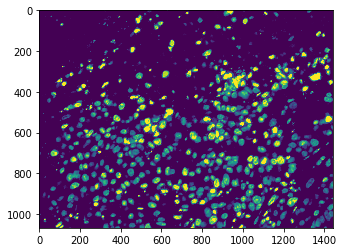

In [51]:
img_test_n = plt.imread('img_test_n.tif') #blue channel of image taken in my lab, exported directly from the microscope and cropped
plt.imshow(img_test_n)

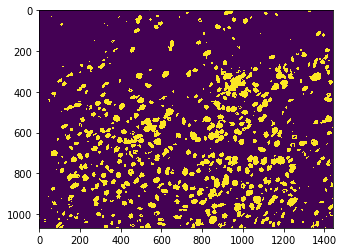

In [57]:
img_test_n_filt = (img_test_n>90).astype(int) #filtering to a value I'm most comfortable with the program using
plt.imshow(img_test_n_filt) #90 seems like a good value

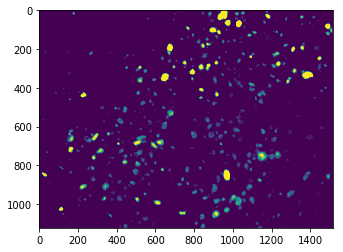

In [58]:
img_test_g = plt.imread('img_test_g.tif') #green channel
plt.imshow(img_test_g)

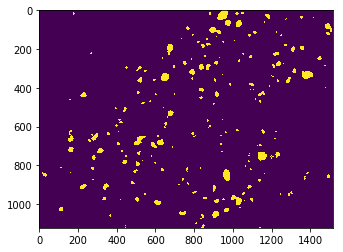

In [62]:
img_test_g_filt = (img_test_g>80).astype(int)
plt.imshow(img_test_g_filt) # 80 seems like a good value here

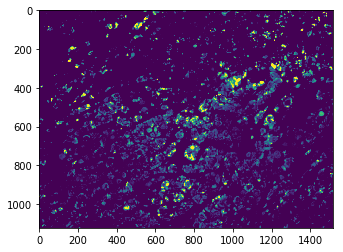

In [64]:
img_test_r = plt.imread('img_test_r.tif') # red channel, much fewer discrete boundaries than the other examples
plt.imshow(img_test_r)

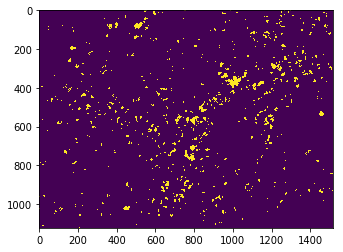

In [67]:
img_test_r_filt = (img_test_r>110).astype(int) #110 might be a good value, but it's hard to say
plt.imshow(img_test_r_filt)

In [68]:
final(img_test_g, 80, img_test_r, 110, img_test_n, 90)

TOTAL CELLS: 665
Green Cells: 293
Red Cells: 83
Green and Red Cells: 102
None Cells: 187


# IT WORKS!!!!!!